In [1]:
import os
import h5py
import math
import gc
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
gc.collect()
torch.cuda.empty_cache()

RANDOM_SEED = 42

# 固定隨機性
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
def plot_images(images: np.ndarray, labels: np.ndarray | None = None, cmap: str | None = None) -> None:
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    n = min(10, images.shape[0])
    for i in range(n):
        axes[i].imshow(images[i], cmap=cmap)
        if labels != None:
            axes[i].set_title(labels[i])
        axes[i].axis("off")
    fig.tight_layout()

In [4]:
from skimage import io
dir = "./datasets/isbi-challenge-dataset/"
train_images = np.asarray(io.imread(dir + "train-volume.tif"))[:, None, :, :]/255.0
train_labels = np.asarray(io.imread(dir + "train-labels.tif"))[:, None, :, :]/255.0
test_images = np.asarray(io.imread(dir + "test-volume.tif"))[:, None, :, :]/255.0

In [5]:
# print shapes
print("train_images shape:", train_images.shape)
print("train_labels shape:", train_labels.shape)
print("test_images shape:", test_images.shape)

train_images shape: (30, 1, 512, 512)
train_labels shape: (30, 1, 512, 512)
test_images shape: (30, 1, 512, 512)


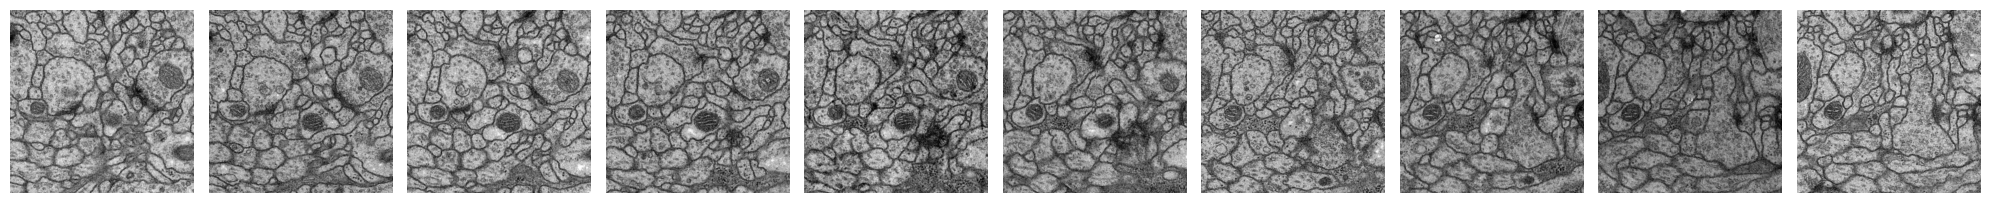

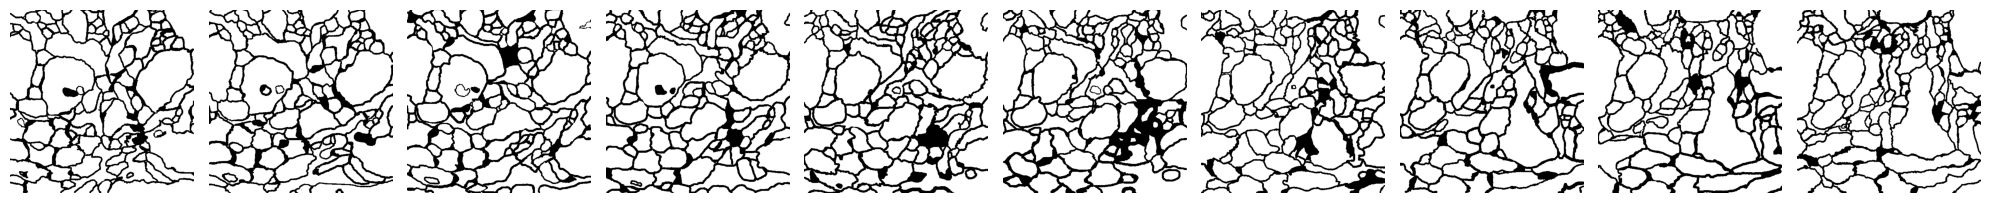

In [6]:
plot_images(train_images[:10][:, 0, :, :], cmap="gray")
plot_images(train_labels[:10][:, 0, :, :], cmap="gray")
# plot_images(test_images[:10][:, 0, :, :], cmap="gray")

In [7]:
def crop(images: np.ndarray, new_h: int, new_w: int) -> np.ndarray:
    h_start = int((images.shape[2] - new_h) / 2)
    w_start = int((images.shape[3] - new_w) / 2)
    cropped_images = images[:, :, h_start:h_start+new_h, w_start:w_start+new_w]
    return cropped_images

In [8]:
def unet_output_dim(input_dim: int, n_pool: int = 4) -> int:
    dim = input_dim
    # downsampling
    for _ in range(n_pool):
        dim = (dim - 4) // 2
    # bottom
    dim = dim - 4
    # upsampling
    for _ in range(n_pool):
        dim = dim * 2 - 4
    return dim

In [9]:
# crop labels
output_dim = unet_output_dim(train_labels.shape[2])
train_labels = crop(train_labels, output_dim, output_dim)

print("train_images shape:", train_images.shape)
print("train_labels shape:", train_labels.shape)

train_images shape: (30, 1, 512, 512)
train_labels shape: (30, 1, 324, 324)


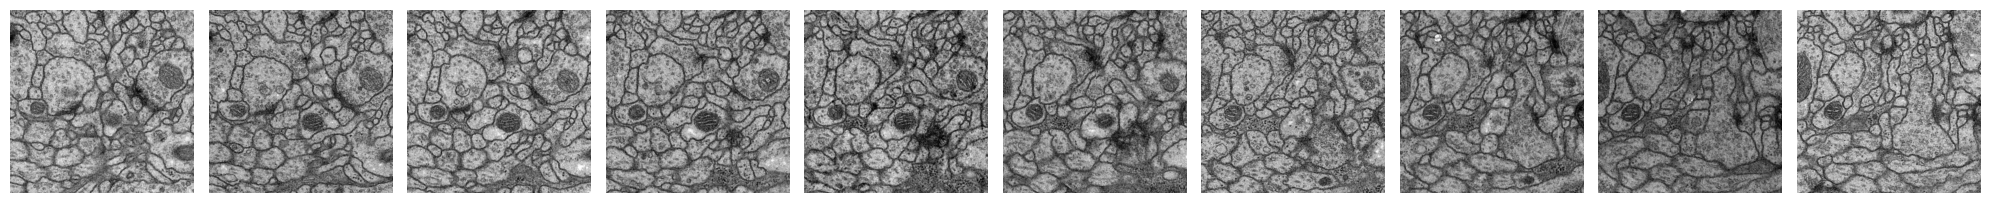

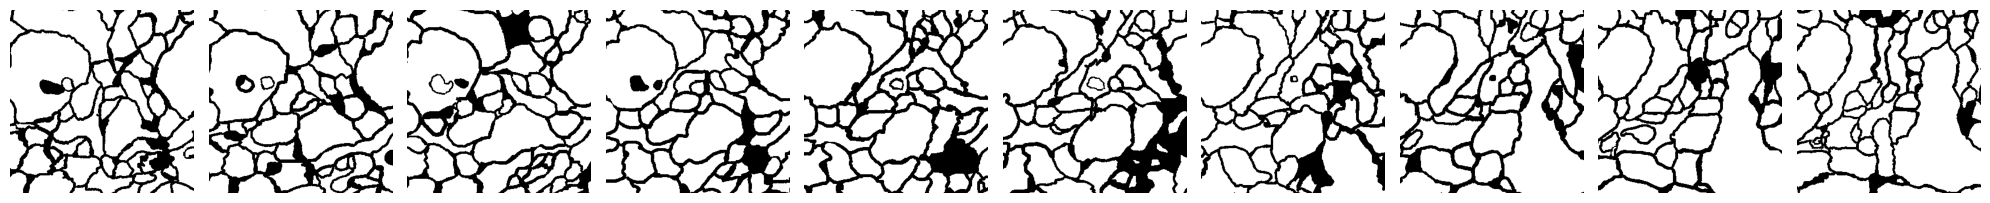

In [10]:
plot_images(train_images[:10][:, 0, :, :], cmap="gray")
plot_images(train_labels[:10][:, 0, :, :], cmap="gray")

In [11]:
temp = torch.tensor(train_labels)
temp.shape[0]

30

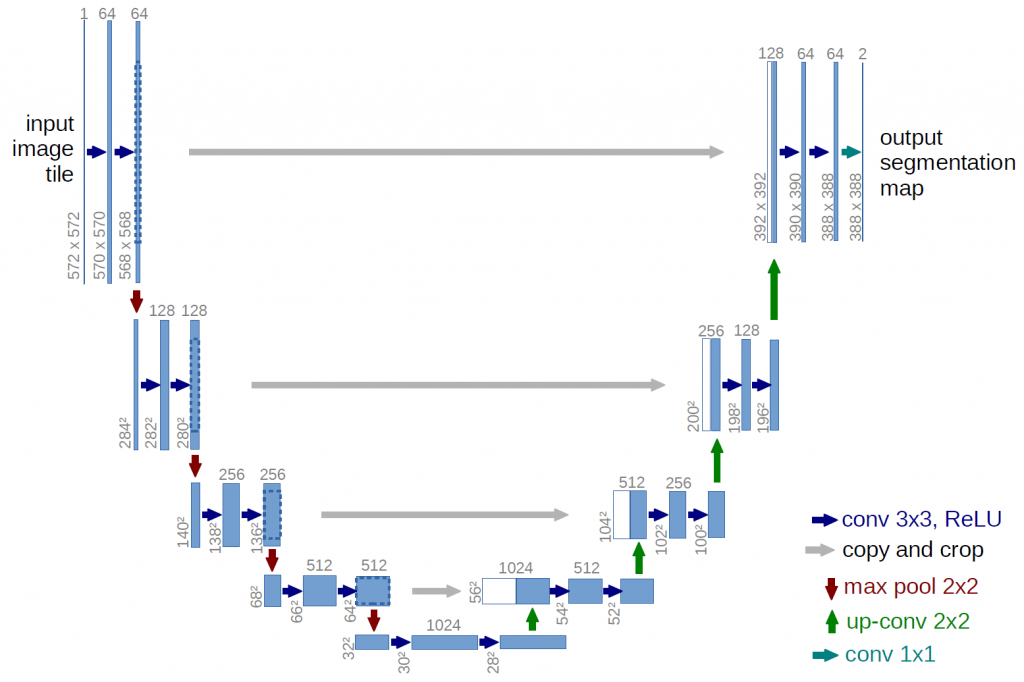

In [12]:
class Conv2dBlock(torch.nn.Module):
    """Decrease height and width of a given tensor"""
    def __init__(self, input_channels: int, output_channels: int, kernel_size: int = 3, padding: int = 0) -> None:
        super(Conv2dBlock, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
    

class UNet(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 2, hidden_channels: int = 64, device: torch.device = torch.device("cpu")) -> None:
        super(UNet, self).__init__()
        self.device = device
        self.left1 = Conv2dBlock(in_channels, hidden_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.left2 = Conv2dBlock(hidden_channels, hidden_channels*2)
        self.left3 = Conv2dBlock(hidden_channels*2, hidden_channels*4)
        self.left4 = Conv2dBlock(hidden_channels*4, hidden_channels*8)
        self.bottom = Conv2dBlock(hidden_channels*8, hidden_channels*16)
        self.up4 = nn.ConvTranspose2d(hidden_channels*16, hidden_channels*8, kernel_size=2, stride=2, padding=0)
        self.right4 = Conv2dBlock(hidden_channels*16, hidden_channels*8)
        self.up3 = nn.ConvTranspose2d(hidden_channels*8, hidden_channels*4, kernel_size=2, stride=2, padding=0)
        self.right3 = Conv2dBlock(hidden_channels*8, hidden_channels*4)
        self.up2 = nn.ConvTranspose2d(hidden_channels*4, hidden_channels*2, kernel_size=2, stride=2, padding=0)
        self.right2 = Conv2dBlock(hidden_channels*4, hidden_channels*2)
        self.up1 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels, kernel_size=2, stride=2, padding=0)
        self.right1 = Conv2dBlock(hidden_channels*2, hidden_channels)
        self.final_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=1)
        self.to(self.device)

    def crop(self, tensor_images: torch.Tensor, new_h: int, new_w: int) -> torch.Tensor:
        h_start = int((tensor_images.shape[2] - new_h) / 2)
        w_start = int((tensor_images.shape[3] - new_w) / 2)
        cropped_images = tensor_images[:, :, h_start:h_start+new_h, w_start:w_start+new_w]
        return cropped_images.clone()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder
        left1_out = self.left1(x)
        left2_out = self.left2(self.maxpool(left1_out))
        left3_out = self.left3(self.maxpool(left2_out))
        left4_out = self.left4(self.maxpool(left3_out))

        # Bottom
        bottom_out = self.bottom(self.maxpool(left4_out))

        # Decoder
        up4_out = self.up4(bottom_out)
        right4_in = torch.cat((self.crop(left4_out, up4_out.shape[2], up4_out.shape[3]), up4_out), dim=1)
        right4_out = self.right4(right4_in)

        up3_out = self.up3(right4_out)
        right3_in = torch.cat((self.crop(left3_out, up3_out.shape[2], up3_out.shape[3]), up3_out), dim=1)
        right3_out = self.right3(right3_in)

        up2_out = self.up2(right3_out)
        right2_in = torch.cat((self.crop(left2_out, up2_out.shape[2], up2_out.shape[3]), up2_out), dim=1)
        right2_out = self.right2(right2_in)

        up1_out = self.up1(right2_out)
        right1_in = torch.cat((self.crop(left1_out, up1_out.shape[2], up1_out.shape[3]), up1_out), dim=1)
        right1_out = self.right1(right1_in)

        output = self.final_conv(right1_out)
        return output

In [13]:
# model = UNet(in_channels=1, out_channels=1, hidden_channels=64).to(device)
# output = model(torch.randn(1, 1, 572, 572).to(model.device))
# print("UNet output shape:", output.shape)

In [14]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray) -> None:
        self.images = images
        self.labels = labels

    def __len__(self) -> int:
        return self.images.shape[0]

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        image = torch.Tensor(self.images[idx])
        label = torch.Tensor(self.labels[idx])
        return image, label

In [15]:

def train(
    model: nn.Module, 
    train_loader: torch.utils.data.DataLoader, 
    criterion: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    progress_title: str = "Epoch"
) -> float:
    model.train()
    total_loss = 0.0
    total_count = 0
    loop = tqdm(train_loader, desc=progress_title)
    for images, labels in loop:
        images = images.to(model.device, dtype=torch.float32)
        labels = labels.to(model.device, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.shape[0]
        total_count += images.shape[0]
        loop.set_postfix(loss=f"{loss.item():.4f}", avg_loss=f"{total_loss / total_count:.4f}")

    return total_loss / total_count



In [16]:
model = UNet(in_channels=1, out_channels=1, hidden_channels=64, device=device)

In [17]:
epochs = 30
learning_rate = 2e-4
train_loader = torch.utils.data.DataLoader(
    Dataset(train_images, train_labels),
    batch_size=4,
    shuffle=True,
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [18]:
print(
    f"Epochs: {epochs}\n"
    f"Learning rate: {learning_rate}\n"
    f"Using device: {device}\n"
)
for epoch in range(epochs):
    train(model, train_loader, criterion, optimizer, progress_title=f"Epoch {epoch + 1}/{epochs}")
    scheduler.step()

Epochs: 30
Learning rate: 0.0002
Using device: cuda



Epoch 30/30: 100%|██████████| 8/8 [00:01<00:00,  5.38it/s, avg_loss=0.2931, loss=0.3107]


In [19]:
with torch.no_grad():
    # outputs = model(torch.tensor(train_images[:10], device=device, dtype=torch.float32))
    outputs = model(torch.tensor(test_images[:10], device=model.device, dtype=torch.float32))
    outputs = torch.sigmoid(outputs)
    outputs = torch.where(outputs > 0.5, torch.tensor(1.0), torch.tensor(0.0))
    outputs = outputs.cpu().detach().numpy()

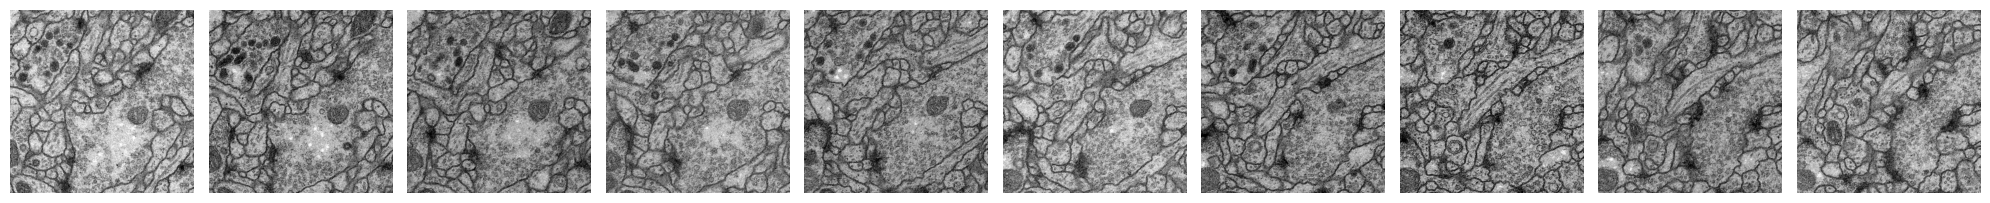

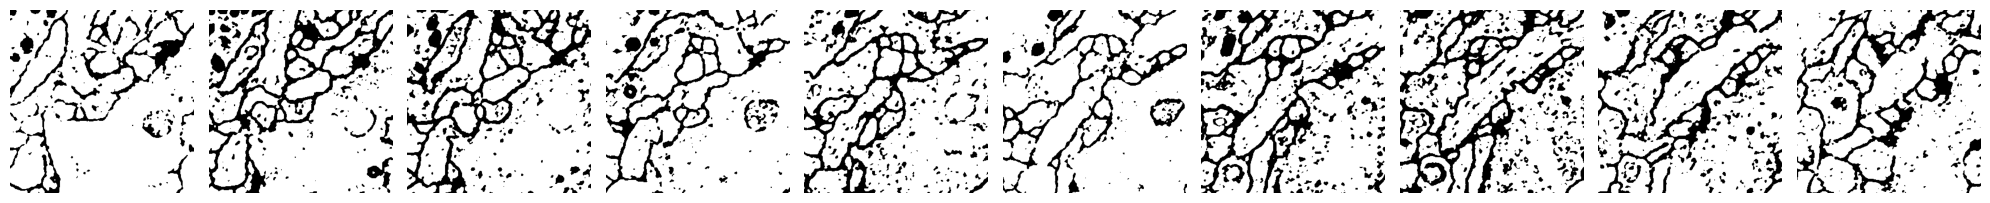

In [20]:
# plot_images(train_images[:10][:, 0, :, :], cmap="gray")
# plot_images(train_labels[:10][:, 0, :, :], cmap="gray")
plot_images(test_images[:10][:, 0, :, :], cmap="gray")
plot_images(outputs[:10][:, 0, :, :], cmap="gray")

In [21]:
# del model
# gc.collect()
# torch.cuda.empty_cache()